In [1]:
%cd /home/q123/Desktop/explo

import torch 
import gpytorch 
import logging
import logging.config

from src.helpers import setup_experiment
from src.trainer import Trainer
from src.optimizers.gibo import GIBOptimizer
from src.optimizers.vanilla_bo import BOptimizer
from src.config import get_configs

logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()
print("hello")


/home/q123/Desktop/explo


/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/gym/envs/registration.py:415: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
pybullet build time: Jun 23 2022 12:25:14


hello


MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]
MyRBF received 16000 use_ard True
 Gibo will use 32 last points to fit GP and 16 info samples
theta_i tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
MyRBF received 2000 use_ard True


/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


acq_diff 0.002816846827045083
acq_diff 0.0022671245969831944
breaking info gathering after 3 steps
model mean constant Parameter containing:
tensor([-0.0350], requires_grad=True)
inv hessian mean 87.3235092163086 gradient mean 1.4819577932357788 
theta_i tensor([[ 6.6696e-01, -1.4702e+00,  1.9246e-01,  1.9869e-02,  7.9430e-03,
         -7.6956e-03, -6.0270e-03,  2.4995e-02, -2.5305e+00,  6.0654e+00,
         -1.4222e-01, -2.0959e-01,  1.7150e-01, -9.4623e-02,  1.6822e-01,
         -7.7476e-02]])
MyRBF received 2000 use_ard True
acq_diff 0.5767916440963745
acq_diff 0.19663000106811523
acq_diff 0.17731213569641113
acq_diff 0.1608715057373047
acq_diff 0.10866165161132812
acq_diff 0.11382555961608887
acq_diff 0.053205013275146484
acq_diff 0.07404136657714844
acq_diff 0.044939279556274414
acq_diff 0.04444766044616699
acq_diff 0.036041259765625
acq_diff 0.05153393745422363
acq_diff 0.02371835708618164
acq_diff 0.021500349044799805
acq_diff 0.020175457000732422
model mean constant Parameter c

/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


acq_diff 0.004030793905258179
acq_diff 0.0028352029621601105
breaking info gathering after 3 steps
model mean constant Parameter containing:
tensor([0.4793], requires_grad=True)
inv hessian mean 21.58934783935547 gradient mean 0.2056054174900055 
current 0.5692793130874634 / max 0.6337883472442627 /batch_mean 0.5692793130874634 /batch_max 0.5692793130874634 
##############################
covar_lengthscale max 150.0 / min 2.4769694805145264                      covar_outputscale 0.009999999776482582                     noise 0.009999999776482582
##############################
MLL : 1.288460373878479
grad_mean : max 0.02393517643213272 /  min -0.09919165074825287
grad_covar : max 0.010411499999463558 /  min 9.999999717180685e-10
theta_i tensor([[ 1.3011, -3.9421,  2.4466,  1.9714,  5.8952, -2.2948, -1.3397,  0.0711,
         -1.6949,  5.0047, -0.1841, -0.5537,  0.2975, -0.3913,  0.6219, -0.2019]])
MyRBF received 2000 use_ard True
acq_diff 0.0019011422991752625
acq_diff 0.004878006875514

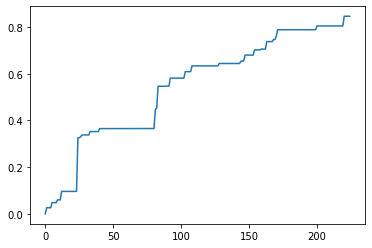

In [2]:
#env_name = "CartPole-v1"
env_name = "Swimmer-v4"
#env_name = "Hopper-v2"
kernel_name = "rbfstate" ## "linearstate" /"rbfstate"

env_config,likelihood_config,kernel_config,optimizer_config,trainer_config = get_configs(env_name,kernel_name)
additional_layers=[] ### can be empty or [8,7] for adding 2 layers with width 8,7 respectively

optimizer_config = {
        "n_eval":1, ## 3 for cartpole (very noisy)
        ### for GIBO
        "n_max":32, 
        "n_info_samples":16,
        "delta":0.1, ## 0.01 for cartpole
        ### hessian normalisation applies only for rbf
        "normalize_gradient": True,
        "standard_deviation_scaling":False,
}

likelihood_config = {
                "noise_hyperprior":gpytorch.priors.torch_priors.UniformPrior(a=0.01,b=0.05),
                "noise_constraint":gpytorch.constraints.constraints.Interval(0.01,0.05)
                }


kernel_config = {
        "use_ard":True,
        "kernel_name":kernel_name,
        #"lengthscale_hyperprior":gpytorch.priors.torch_priors.GammaPrior(5,0.9),
        "lengthscale_constraint":gpytorch.constraints.constraints.Interval(0.01,150),
        #"outputscale_hyperprior":gpytorch.priors.torch_priors.GammaPrior(2,0.4),
        "outputscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.01),
        }

trainer_config = {
        "n_steps":40, 
        "report_freq":1,
        "save_best":False,
        "wandb_logger":False,
}

model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config,additional_layers)


### Chose optimizer 
#optimizer = BOptimizer(**optimizer_config)
optimizer = GIBOptimizer(model,**optimizer_config)
trainer = Trainer(model,objective_env,optimizer,**trainer_config)
rslt= trainer.run()

### ADD LR SCHEDULAR  / FIX DISCRETIZATION ===> ENJOY WEEKEND :DDD

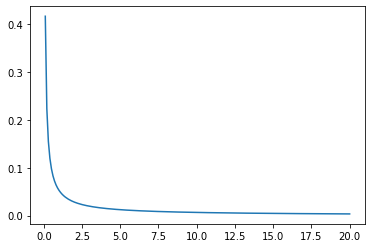

In [3]:
import scipy.stats as stats 
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.1
beta = 0.001
x = np.linspace (0, 20, 200) 
y1 = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x,y1)